# A New Keynesian model

In this notebook we demonstrate the basic workflow of setting up and solving a linear DSGE models in sequence space. All in the context of a simple linearized NK model.

For more examples and information on the SSJ toolkit, please visit the sequence-space jacobian (SSJ) [GitHub page](https://github.com/shade-econ/sequence-jacobian).

1. Set up a linarized NK model
2. Steady state
3. Linearized impulse responses

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1 Set up a New Keyensian model


Let's consider a standard linearized New Keynesian model with the following equilibrium conditions

$$
\textbf{F}_t(\textbf{X}, Z) \equiv 
\begin{pmatrix}
\hat{y}_t +\sigma[\hat{i}_t-\{\hat{\pi}_{t+1}\}]+E_t\{\hat{y}_{t+1}\}
\\
\hat{\pi}_t - \kappa (\hat{y}_t-\hat{y}_t^{flex}) -\beta E_t \{\hat{\pi}_{t+1}\}
\\
\hat{i}_t - \phi_\pi\hat{\pi}_t- v_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0  \end{pmatrix},
\qquad t = 0, 1, \dots 
\tag{1}
$$

### 1.1 Directed Acyclic Graph (DAG) representation

The first step of solving the model is to come up with a Directed Acyclic Graph (DAG) representation for it and specify its blocks.

These blocks are collections of the model's equilibrium conditions, typically written in terms of the conceptual components of the model --- firm, household, market clearing conditions --- where each block takes a set of parameters and variables as inputs and produces another set as outputs. Formally, a block is a mapping between two sets of real sequences. 

<!-- Let $\mathbf{X} \equiv (x_t)_{t \in \mathbb{N}}$ denote a real sequence, and $\mathcal{I}$ and $\mathcal{O}$ denote the (finite) index sets of inputs and outputs. So, a block is a function $h: \{\mathbf{X}^i\}_{i \in \mathcal{I}} \to \{\mathbf{X}^o\}_{o \in \mathcal{O}}.$ -->

The DAG serves as the organizing framework for these blocks, which reduce the total set of variables and equations from those in the equilibrium conditions to the minimum number of target equations and associated unknown variables/parameters needed to represent the same system. The rest of the variables/equations in the system can then be written as explicit functions of these unknowns and collected into blocks.

#### The NK DAG
The 3 equations of the RBC model can be organized as three blocks which form a DAG in two unknowns $U = \{y\}$ and one target, the Euler equation: 
$$
\textbf{H}_t(U, Z) = 0
$$

### 1.2 Representing our NK model

SSJ has several subclasses of the abstract **Block** class.
- `SimpleBlock` for explicit aggregate equilibrium conditions
- `SolvedBlock` for implicit aggregate equilibrium conditions
- `HetBlock` for collective actions of heterogeneous agents
- `CombinedBlock` for combination of multiple blocks

As we will see, blocks have a unified interface. By mixing these types blocks, we can represent most DSGE models. 

To represent our linearized NK model, we only need simple blocks. In the non-linear version we will also use solved blocks. Heterogeneous agent blocks are for HANK style models.

In [2]:
from sequence_jacobian import simple, create_model

@simple
def flex(a):
    yflex = a* (1 + varphi) / (gamma + varphi ) 
    return yflex

@simple
def nkpc(pi, yflex, beta, kappa):
    y = yflex + 1 / kappa * (pi - beta * pi(+1))
    return y

@simple
def central_bank(pi, v, phi_pi):
    i = phi_pi * pi + v
    return i

@simple
def mkt_clearing(y, i, pi, gamma):
    euler = gamma * y + i - pi(+1) - gamma * y(+1)
    r = i - pi(+1)
    c = y
    return euler, r, c

- SimpleBlocks are initialized as regular Python functions, endowed with the decorator `@simple`. 
- Inside the function, we can refer to **leads/lags** of any inputs. The convention is as follows: 
   - `Y` refers to $Y_t$
   - `Y(-k)` refers to $Y_{t-k}$
   - `Y(k)` refers to $\mathbb{E}_t[Y_{t+k}]$
- We cannot ask for leads/lags of variables in the same SimpleBlock in which they were created. For example, we could not add the line `Y_lag = Y(-1)` to the firm block above. If we really wanted it, we could create a new SimpleBlock that takes `Y` as input and returns `Y_lag = Y(-1)`.
- Use SimpleBlocks only with **univariate** inputs and outputs. This is not a strict rule, but deviating from it imposes somewhat subtle restrictions on the model that we won't discuss here.   
- Of course, we have to import the constructor ``simple`` from the SSJ package before we can use it. For convenience, such commonly used functions can be imported from the top level `sequence_jacobian`, without having to remeber their precise location.  

Recall that every block (including simple blocks) represents a function in sequence space.

In [3]:
from sequence_jacobian import simple, create_model

@simple
def flex(a):
    yflex = a* (1 + varphi) / (gamma + varphi ) 
    return yflex

@simple
def nkpc(pi, yflex, beta, kappa):
    y = yflex + 1 / kappa * (pi - beta * pi(+1))
    return y

@simple
def central_bank(pi, v, phi_pi):
    i = phi_pi * pi + v
    return i

@simple
def mkt_clearing(y, i, pi, gamma):
    euler = gamma * y + i - pi(+1) - gamma * y(+1)
    r = i - pi(+1)
    c = y
    return euler, r, c

Next, we combine the 3 simple blocks to get the linear NK model. 

In [4]:
nk = create_model([flex, nkpc, central_bank, mkt_clearing], name="NK")

print(nk)
print(f"Blocks: {nk.blocks}")

<Model 'NK'>
Blocks: [<SimpleBlock 'central_bank'>, <SimpleBlock 'flex'>, <SimpleBlock 'nkpc'>, <SimpleBlock 'mkt_clearing'>]


- The constructor `create_model` takes a list of blocks and (optionally) a name for the model.
- The order of blocks in the input list does not matter. When a `Model` is created, the constituent blocks are sorted in the correct order of evaluation based on their inputs and outputs. This is called a topological sort. The SSJ toolkit represents models just like we draw them, as a directed acyclic graph (DAG).
- `Model` is an alias for `CombinedBlock` that we use only for complete macro models. A model may include multiple nested CombinedBlocks. Our convention is to use `create_model` for fully-specified DSGE models, and use the alias `combine` in all other cases.

### 1.3 Automated DAG visualization

We can visualize DAGs automatically using the `utilities/drawdag` module. The `drawdag` function takes a combined block (e.g. `rbc`), and the names of exogenous variables (`inputs`), unknowns, and targets.

This feature requires the [Graphviz](https://www.graphviz.org/) graph drawing software and the corresponding [Python package](https://pypi.org/project/graphviz/). Graphviz is not included in the Anaconda Python distribution, so you need to install it manually if you'd like to use it.

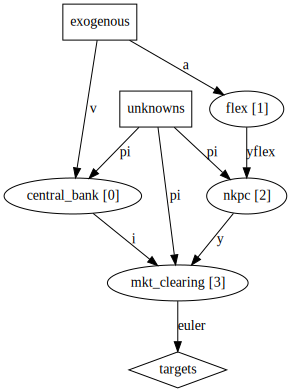

In [5]:
from sequence_jacobian.utilities.drawdag import drawdag

unknowns = ['pi']
targets = ['euler']
inputs = ['a', 'v']

drawdag(nk, inputs, unknowns, targets, save="nk.png")

With graphviz installed, the output of the cell above should look like this. 

**Note**: In the above DAG, we omit the various other variables/parameters that are pre-specified so the figure does not become too cluttered. However, one could visualize other variables such as the capital depreciation rate, $\delta = 0.025$ in our standard calibration, as being defined outside of the DAG --- they could be potential unknowns but in this configuration we simply fix their values.

## 2 Steady state

The next step of solving a model is to compute its steady state. The SSJ toolkit provides functionality for computing a model's steady state from its DAG representation. This can be very convenient, but is optional. One can always compute the steady state manually.

Since we linearize around the  steady state, the linearized variables by definition are 0 in the steady state.

In [6]:
# initial parameters
gamma = 1
beta = 0.99
phi_pi = 1.5
kappa = 0.1

# Other parameters 
varphi = 0.5  # assumption

# steady state values
calibration = {'a': 0, 'v': 0, 'y': 0, 'c': 0, 'r': 0, 'i': 0, 'gamma': gamma, 'beta': beta, 'phi_pi': phi_pi, 'kappa': kappa}

# solve for steady state (we know it, but running this routine helps us check for mistakes)
unknowns_ss = {'pi': 0}
targets_ss = { "euler": 0}

ss = nk.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="broyden_custom")

# checking that we are in the steady state that we expect
assert np.allclose(ss['pi'], 0)
assert np.allclose(ss['euler'], 0)

- `solve_steady_state` is a method that all Blocks have. It takes a calibration, unknowns to solve for (name and initial guess), and targets (name and value) that should be satisfied. 
- The `solver` keyword argument specifies which root-finding algorithm will be used to solve for the steady state. Any of the generic root-finding algorithms listed in `scipy.optimize` can be used.
- `solve_steady_state` returns a `SteadyStateDict` object, which is similar to Python dictionaries with some helpful extra functionality.
- To evaluate a block with constant inputs (without internal calibration), use the `steady_state` method, whoch takes only a calibration.

## 3 Linearized solution

The linearized impulse responses of the model are fully characterized by the general equilibrium Jacobians $G = H_U^{-1}H_Z$ These matrices map *any* sequence of shocks into an impulse response, e.g. $dC = G^{C,Z} dZ.$ Once we have them, we're pretty much done!

We can get all of these in a single call to the `solve_jacobian` method of the `nk` object. This function takes in the `SteadyStateDict` we obtained from calling `nk.solve_steady_state`, the names of exogenous shocks, the names of unknown endogenous variables, the names of target equations, and the truncation horizon.

In [7]:
G = nk.solve_jacobian(ss, unknowns, targets, inputs, T=300)

print(G)

<JacobianDict outputs=['pi', 'yflex', 'y', 'i', 'euler', 'r', 'c'], inputs=['a', 'v']>


<!-- ![Automatic DAG for our RBC model](dag/RBC.png)  -->

For comparison we will solve the same model but with more flexible prices $\kappa=1$ rather than $\kappa=0.1$. This can be done in just a few steps:

In [8]:
# change calibration
calibration2 = calibration.copy()
calibration2['kappa'] = 10

# calculate new steady state
ss2 = nk.solve_steady_state(calibration2, unknowns_ss, targets_ss, solver="broyden_custom")

# calculate new Jacobian
G2 = nk.solve_jacobian(ss2, unknowns, targets, inputs, T=300)

To see the $G$ matrices in action, let's construct a monetary shock. Then we apply the $G$ matrix to map these into impulses responses for, say, output. We multiply by 100 just to get the answer in units of % deviations from steady state.

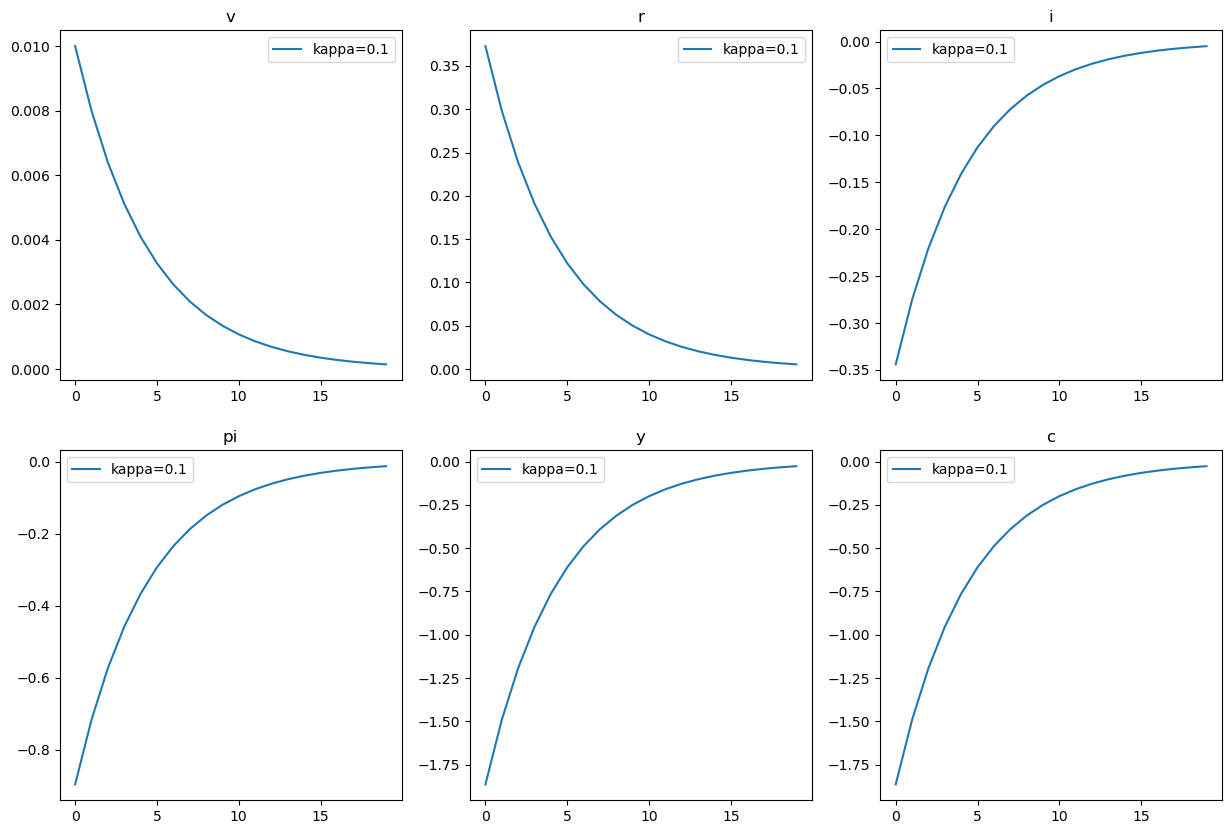

In [9]:
T, Tplot, impact, rho, news = 300, 20, 0.01, 0.8, 10
dv = np.empty((T, 1))
dv[:, 0] = impact * rho**np.arange(T)

# plot responses for shock, nominal interest rate, real interest rate, inflation, output, and employment
plotset = ['v', 'r', 'i', 'pi', 'y', 'c']
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, var in enumerate(plotset):
    if var == 'v':
        irf1 = dv[:Tplot]
        irf2 = dv[:Tplot]
    else:
        irf1 = 100 * (G[var]['v'] @ dv)[:Tplot]
        irf2 = 100 * (G2[var]['v'] @ dv)[:Tplot]
    axi = ax[i // 3, i % 3]
    axi.plot(irf1, label="kappa=0.1")

    axi.set_title(f"{var}")
    axi.xlabel = "quarters"
    axi.ylabel = "% deviation"
    axi.legend()

plt.savefig("nklinearirf.png")


Now a TFP shock:

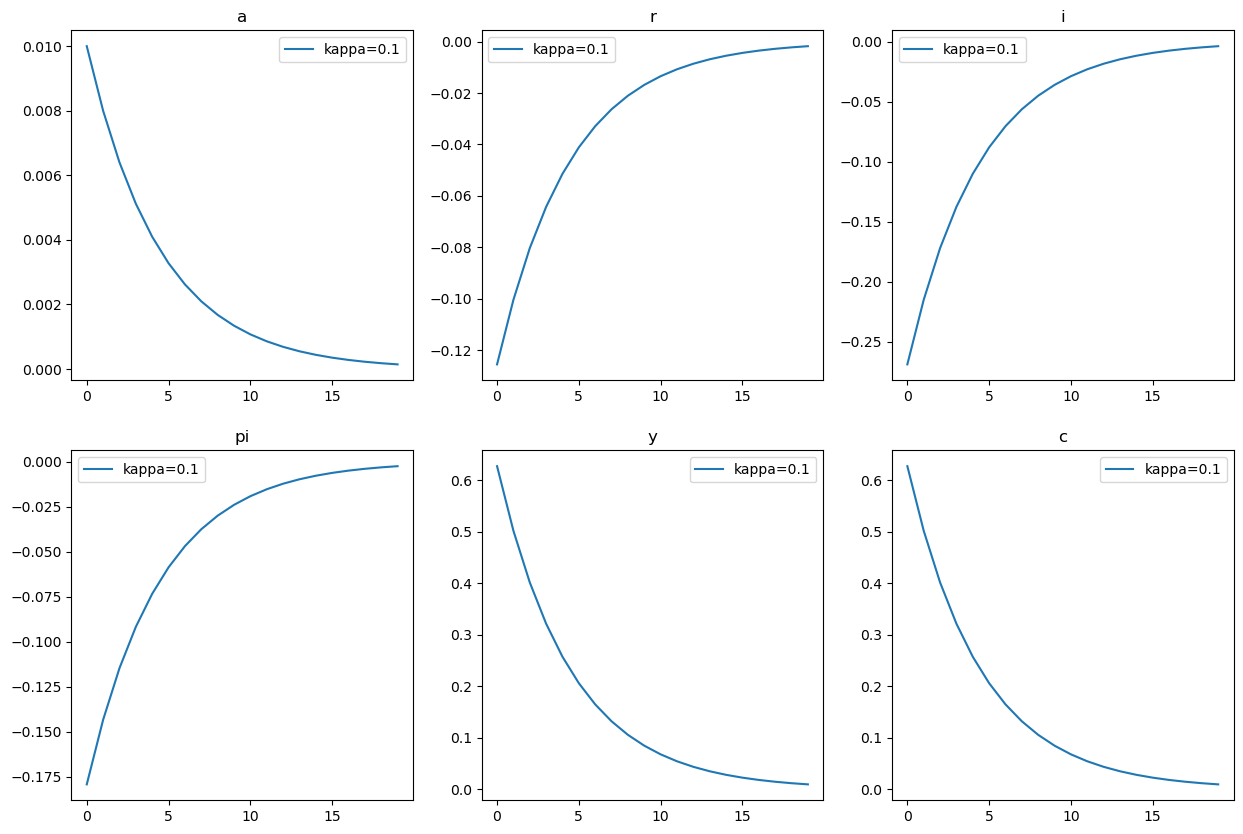

In [10]:
T, Tplot, impact, rho, news = 300, 20, 0.01, 0.8, 10
da = np.empty((T, 1))
da[:, 0] = impact * rho**np.arange(T)

# plot responses for shock, nominal interest rate, real interest rate, inflation, output, and employment
plotset = ['a', 'r', 'i', 'pi', 'y', 'c']
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, var in enumerate(plotset):
    if var == 'a':
        irf1 = da[:Tplot]
        irf2 = da[:Tplot]
    else:
        irf1 = 100 * (G[var]['a'] @ da)[:Tplot]
        irf2 = 100 * (G2[var]['a'] @ da)[:Tplot]
    axi = ax[i // 3, i % 3]
    axi.plot(irf1, label="kappa=0.1")

    axi.set_title(f"{var}")
    axi.xlabel = "quarters"
    axi.ylabel = "% deviation"
    axi.legend()

plt.savefig("nklinearirf_2.png")
